In [72]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error

In [81]:
train = pd.read_csv("data/train.csv", na_values=['na'])
validation = pd.read_csv("data/validation.csv", na_values=['na'])
train.shape, validation.shape

((30000, 44), (23333, 44))

In [82]:
unlabeled = pd.read_csv("data/unlabeled_v2.csv", na_values=['na'])
unlabeled.shape

(23333, 43)

In [5]:
train['class'].value_counts()

2    10000
1    10000
0    10000
Name: class, dtype: int64

###  Functions

In [6]:
bands_all = ['u', 'g', 'r', 'i', 'z']
indx_all = ['0', '1', '2', '3', '4', '5', '6']

In [7]:
def show_missing_values():
    missing_values_df = pd.DataFrame(0, columns=['train', 'validation', 'unlabeled'], index=train.columns)

    missing_values_df['train'] = train.isna().sum()

    missing_values_df['unlabeled'] = unlabeled.isna().sum()
    missing_values_df.at['class', 'unlabeled'] = 0
    missing_values_df.unlabeled = missing_values_df.unlabeled.astype('int64')

    missing_values_df['validation'] = validation.isna().sum()

    return missing_values_df[missing_values_df.any(axis=1)]

In [8]:
def show_classes_distributions_by_index(idx, data):    
    fig, ax = plt.subplots(1, 5, figsize=(10, 3))
    fig.subplots_adjust(wspace=0.7)

    for j in range(5):
        f_name = "{}_{}".format(bands_all[j], idx)
        sns.boxplot(x='class', y=f_name, data=data, ax=ax[j])

# Data Exploration

In [9]:
train.head()

,objid,ra,dec,u_0,g_0,r_0,i_0,z_0,clean,rowc,...,g_5,r_5,i_5,z_5,u_6,g_6,r_6,i_6,z_6,class
0,78023,121.079395,-9.343143,25.46583,22.53827,21.52258,NaN,NaN,1,107.03430,...,-0.184090,-0.054633,NaN,NaN,6,5,6,5,2,0
1,67239,121.080753,-9.339397,23.64559,24.57786,21.76326,20.94348,21.52855,1,134.68570,...,0.371713,-0.128548,-0.122364,NaN,6,8,1,1,0,0
2,48461,121.070386,-9.332728,24.88126,23.49473,22.23877,21.38574,21.51635,1,84.76380,...,0.004125,0.014147,-0.051568,NaN,6,4,6,4,5,0
3,55564,121.083052,-9.334026,23.57384,21.42411,20.43948,19.99905,19.82959,1,177.05670,...,-0.080959,NaN,-0.089301,NaN,3,4,5,2,4,0
4,96180,121.063351,-9.325032,23.85167,20.25245,19.60670,19.18877,19.08231,1,65.37769,...,-0.037828,-0.097120,NaN,0.106472,3,4,7,6,3,0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 44 columns):
objid    30000 non-null int64
ra       30000 non-null float64
dec      30000 non-null float64
u_0      25444 non-null float64
g_0      25496 non-null float64
r_0      25445 non-null float64
i_0      25404 non-null float64
z_0      25519 non-null float64
clean    30000 non-null int64
rowc     30000 non-null float64
colc     30000 non-null float64
rowv     29599 non-null float64
colv     29599 non-null float64
u_1      30000 non-null float64
g_1      30000 non-null float64
r_1      30000 non-null float64
i_1      30000 non-null float64
z_1      30000 non-null float64
u_2      30000 non-null float64
g_2      30000 non-null float64
r_2      30000 non-null float64
i_2      30000 non-null float64
z_2      30000 non-null float64
u_3      24827 non-null float64
g_3      28280 non-null float64
r_3      29273 non-null float64
i_3      29420 non-null float64
z_3      28272 non-null float64

In [11]:
train['class'].value_counts()

2    10000
1    10000
0    10000
Name: class, dtype: int64

## Visualization

### Explore Nans

In [12]:
train.columns[train.isna().any(axis=0)]

Index(['u_0', 'g_0', 'r_0', 'i_0', 'z_0', 'rowv', 'colv', 'u_3', 'g_3', 'r_3',
       'i_3', 'z_3', 'u_4', 'g_4', 'r_4', 'i_4', 'z_4', 'u_5', 'g_5', 'r_5',
       'i_5', 'z_5'],
      dtype='object')

Check, maybe NaN values in some columns occur only for one class 

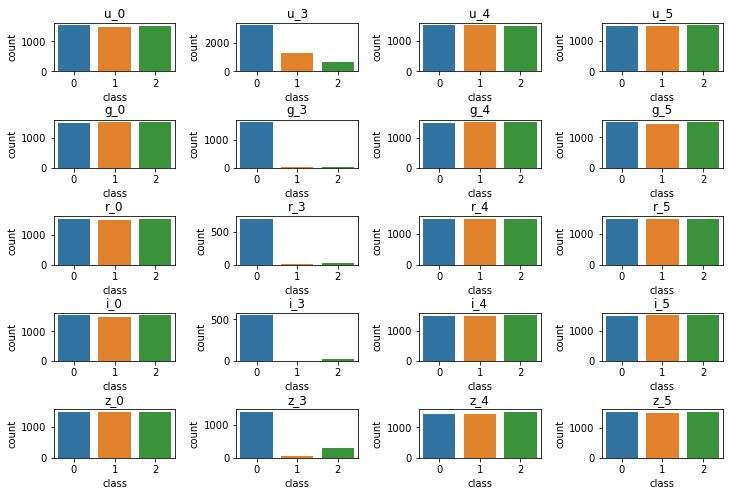

In [9]:
fig, ax = plt.subplots(5, 4, figsize=(12, 8))
fig.subplots_adjust(wspace=0.5, hspace=1)

for i, b in enumerate(bands_all):
    for j, d in enumerate(['0', '3', '4', '5']):
        f_name = "{}_{}".format(b, d)
        samples_with_nan = train[train[f_name].isna()]
        sns.countplot(x='class', data=samples_with_nan, ax=ax[i, j]).set_title(f_name)


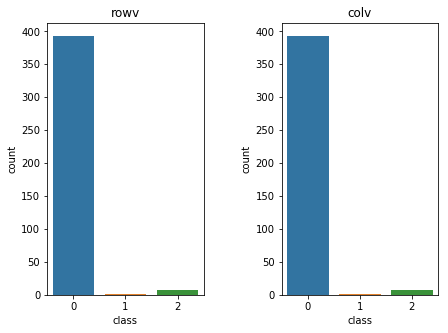

In [13]:
fs = ['rowv', 'colv']

fig, ax = plt.subplots(1, 2, figsize=(7, 5))
fig.subplots_adjust(wspace=0.5)

for i, f in enumerate(fs):
    samples_with_nan = train[train[f].isna()]
    sns.countplot(x='class', data=samples_with_nan, ax=ax[i]).set_title(f)

3-th features and 'rowv' and 'colv' columns have much more missing values in 0th class compared to other classes.   
Columns with boolean values representing if this sample has na for these features may be useful

### Explore data

The majority of features are different light observations, so let's see how they affect classes. 

In [14]:
color_features = ["{}_{}".format(b, str(i)) for b in bands_all for i in range(6)]

train_colors = train[[*color_features, 'class']]
unlabeled_colors = unlabeled[[*color_features]]

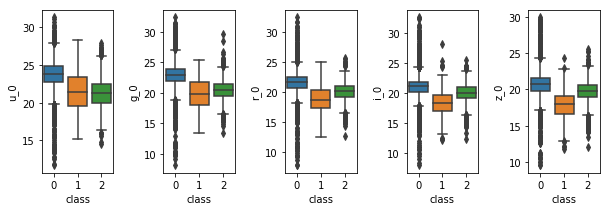

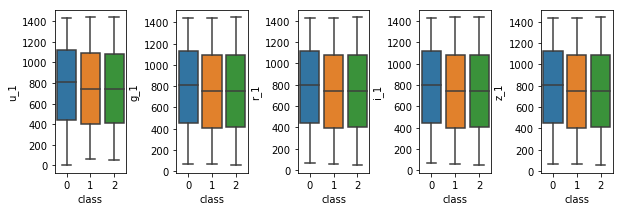

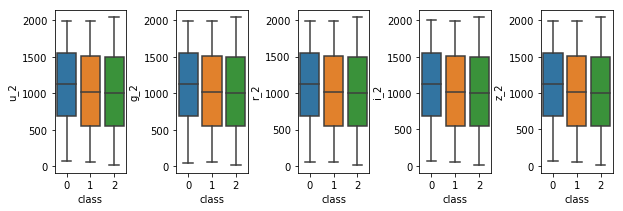

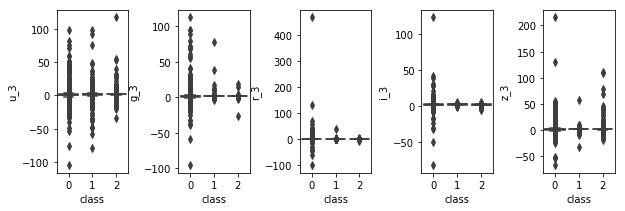

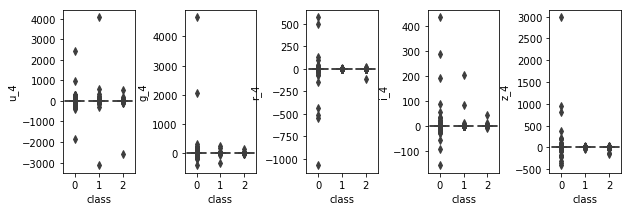

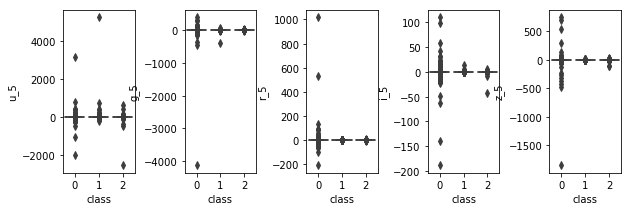

In [15]:
# plot only features which has real-type values
for i in ['0', '1', '2', '3', '4', '5']:
    show_classes_distributions_by_index(i, train_colors)

1-st and 2-nd features are a bit different from others: they don't have outliers, have bigger variance and nearly the same values for different classes    
3-rd, 4-th and 5-th features seem to have very small variance and no effect on class (and have a lot of outliers)   
To be sure let's remove outliers and check again  

0-th feature has a bit differrent values for differrent classes and might be usefull while prediction, so let's investigate it more.

#### 3-th, 4-th and 5-th outliers

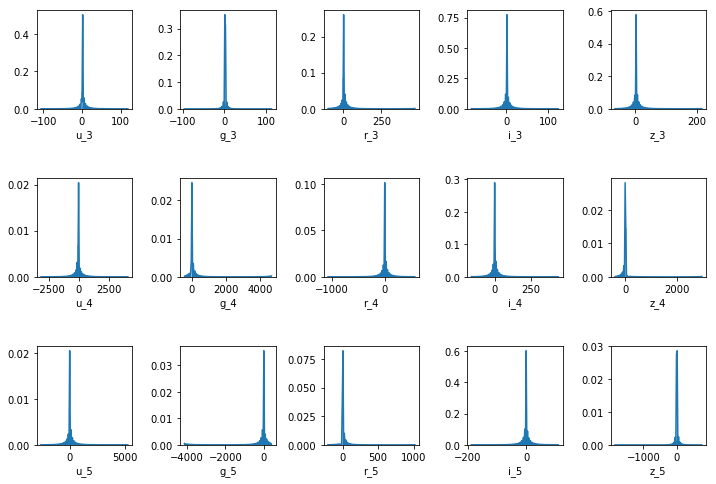

In [16]:
fig, ax = plt.subplots(3,5, figsize=(12,8))
fig.subplots_adjust(hspace=0.7, wspace=0.5)

i, j = 0, 0
for idx in ['3', '4', '5']:
    j = 0
    for b in bands_all:
        f_name = "{}_{}".format(b, idx)
        clean = train[train[f_name].notna()][f_name]
        sns.distplot(clean, ax=ax[i, j])
        j += 1
    i += 1


Using IQR to detect outliers

In [17]:
# detect and save outliers
features = ["{}_{}".format(b, str(i)) for i in range(3, 6) for b in bands_all]

Q1 = train[features].quantile(0.25)
Q3 = train[features].quantile(0.75)

IQR = Q3 - Q1

low_bound = Q1 - 1.5 * IQR
high_bound = Q3 + 1.5 * IQR

clean_data = {}
outliers = {}

for f in features:
    lower_outlier_mask = train[f] < low_bound[f]
    high_outlier_mask = train[f] > high_bound[f]
    
    clean_data[f] = train[~(lower_outlier_mask | high_outlier_mask)]
    outliers[f] = train[lower_outlier_mask | high_outlier_mask]
    print("{}: {} outliers".format(f, len(outliers[f])))

u_3: 1134 outliers
g_3: 4999 outliers
r_3: 2523 outliers
i_3: 1997 outliers
z_3: 4185 outliers
u_4: 5856 outliers
g_4: 4892 outliers
r_4: 3367 outliers
i_4: 2859 outliers
z_4: 3937 outliers
u_5: 6107 outliers
g_5: 5266 outliers
r_5: 3655 outliers
i_5: 3286 outliers
z_5: 3895 outliers


Try to find the reason for outliers

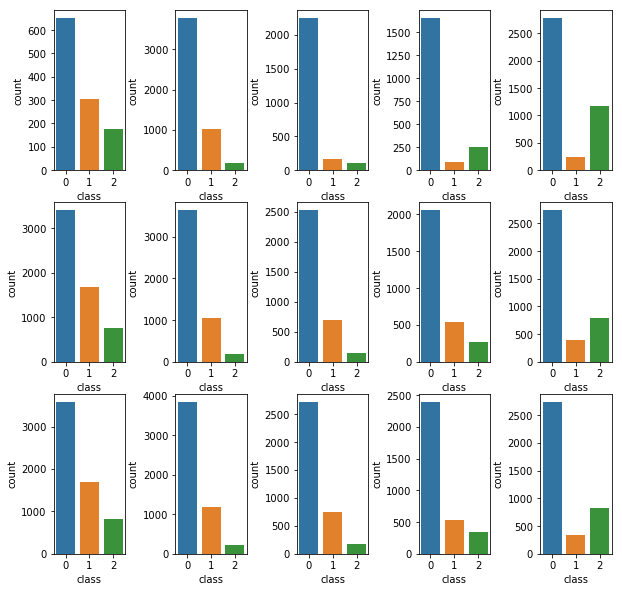

In [18]:
# classes

fig, ax = plt.subplots(3, 5, figsize=(10, 10))
fig.subplots_adjust(wspace=0.7)

i, j = 0, 0
for idx in ['3', '4', '5']:
    j = 0
    for b in bands_all:
        f_name = "{}_{}".format(b, idx)
        sns.countplot(x='class', data=outliers[f_name], ax=ax[i, j])
        j += 1
    i += 1

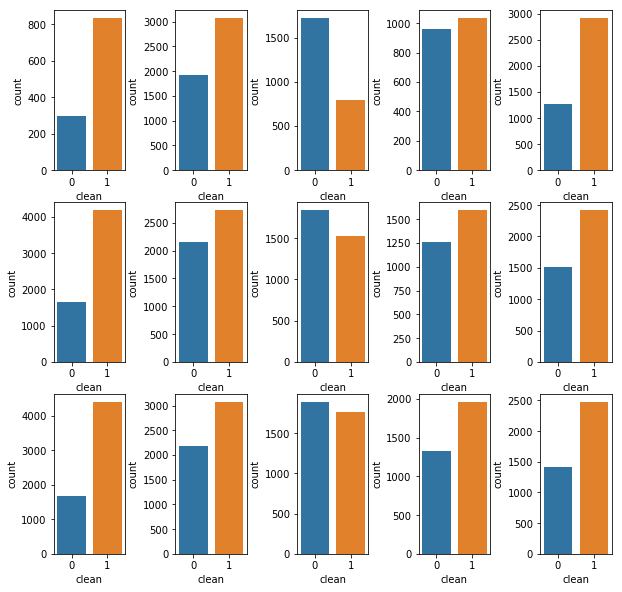

In [19]:
# clean 

fig, ax = plt.subplots(3, 5, figsize=(10, 10))
fig.subplots_adjust(wspace=0.7)

i, j = 0, 0
for idx in ['3', '4', '5']:
    j = 0
    for b in bands_all:
        f_name = "{}_{}".format(b, idx)
        sns.countplot(x='clean', data=outliers[f_name], ax=ax[i, j])
        j += 1
    i += 1

 
Outliers happen not due to 'noisy' shots (in most cases there are more outliers in clean shots)  
Samples of 0-th class has more outliers than 1-st and 2nd ones


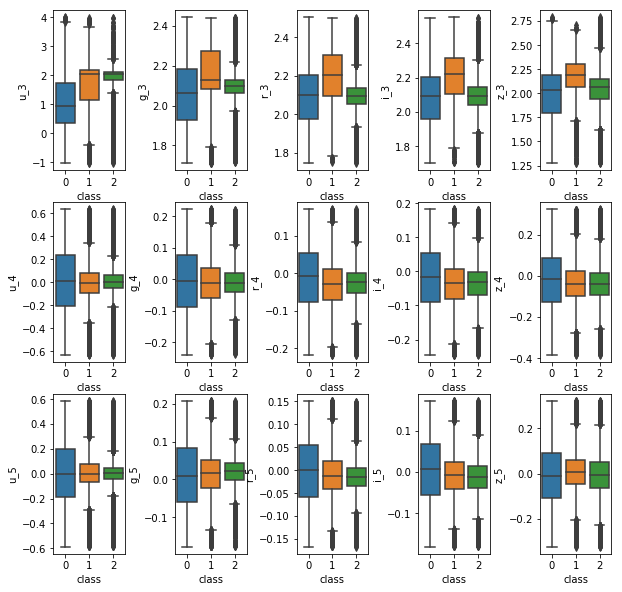

In [20]:
# plot again, without outliers
fig, ax = plt.subplots(3, 5, figsize=(10, 10))
fig.subplots_adjust(wspace=0.7)

i, j = 0, 0
for idx in ['3', '4', '5']:
    j = 0
    for b in bands_all:
        f_name = "{}_{}".format(b, idx)
        sns.boxplot(x='class', y=f_name, data=clean_data[f_name], ax=ax[i, j])
        j += 1
    i += 1
    

Even with outliers removed, 4-th and 5-th features seem to have the same values for each class.  
3-rd features are a bit different for different classes  


#### 0-th color features

0-th color features still have a lot of missing values, but they can probably be usefull while prediction.  


Let's look at 0-th features without outliers

In [21]:
features = ["{}_0".format(b) for b in bands_all]

Q1 = train[features].quantile(0.25)
Q3 = train[features].quantile(0.75)

IQR = Q3 - Q1

low_bound = Q1 - 1.5 * IQR
high_bound = Q3 + 1.5 * IQR

clean_data = {}
outliers = {}

for f in features:
    higher_outlier_mask = train[f] > high_bound[f]
    lower_outlier_mask = train[f] < low_bound[f]
    
    clean_data[f] = train[~(lower_outlier_mask | high_outlier_mask)]
    outliers[f] = train[lower_outlier_mask | high_outlier_mask]
    print("{}: {} outliers".format(f, len(outliers[f])))


u_0: 1962 outliers
g_0: 2003 outliers
r_0: 2162 outliers
i_0: 2191 outliers
z_0: 2193 outliers


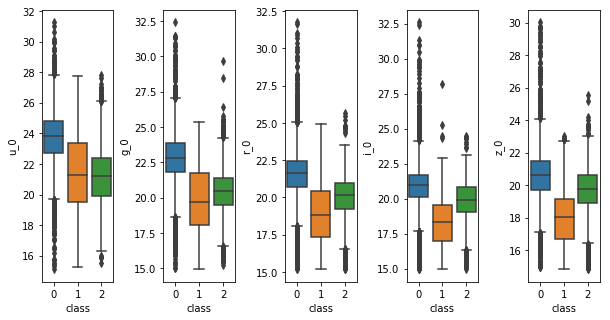

In [22]:
# plot again, without outliers
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
fig.subplots_adjust(wspace=0.7)

for i, b in enumerate(bands_all):
    f_name = "{}_0".format(b)
    sns.boxplot(x='class', y=f_name, data=clean_data[f_name], ax=ax[i])

There is a big difference between different classes, these columns will surely be usefull while prediction.  
Check if we can determine them from other features

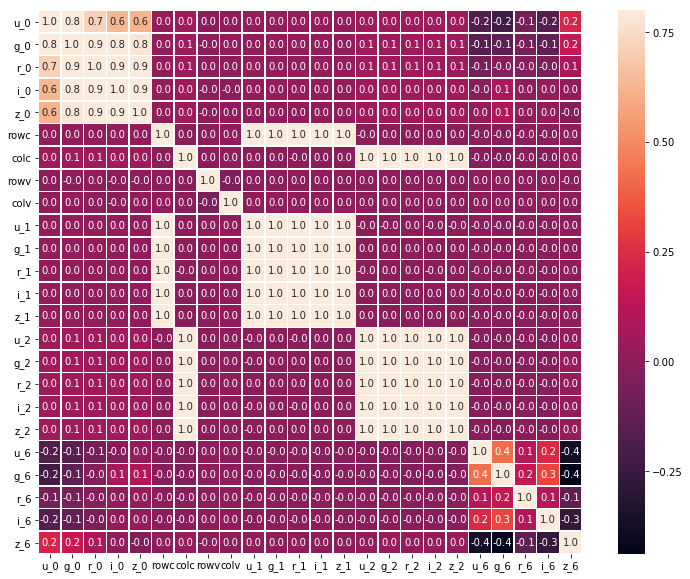

In [23]:
exclude_from_corrmap = ["{}_{}".format(b, n) for n in ['3', '4', '5'] for b in bands_all]
exclude_from_corrmap.extend(['class', 'objid', 'ra', 'dec', 'clean'])

corrmat = train.drop(exclude_from_corrmap, axis=1).corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corrmat,  annot=True, linewidths=.5, fmt= '.1f', vmax=.8, square=True)

0-th features in training set have strong corrlation with one another. ('u_0' and 'g_0', 'g_0' and 'r_0' and so on), so may be predicted one from another    

1-st and 2-nd features are perfectly correlated inside groups *(-_- hm)*   
Also, 1-st features are perfectly correlated with 'rowc' (O.O) and 2-nd features with 'colc' (why?) !!!!!

Check the same in unlabeled dataset

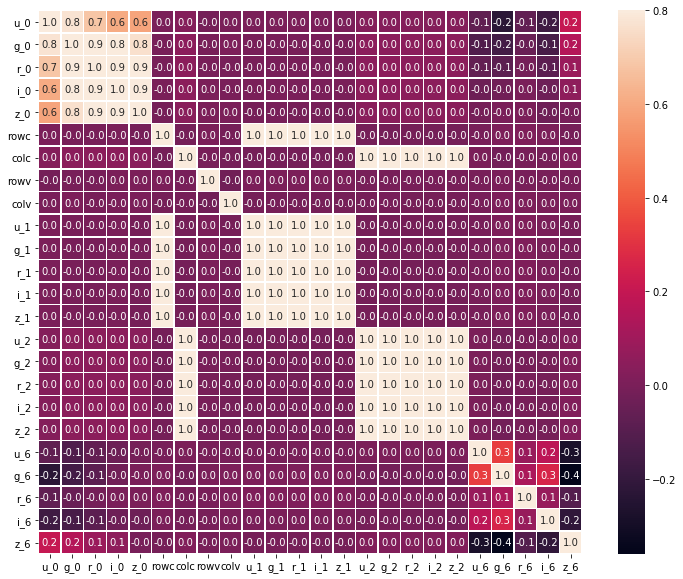

In [24]:
if 'class' in exclude_from_corrmap:
    exclude_from_corrmap.remove('class')

corrmat = unlabeled.drop(exclude_from_corrmap, axis=1).corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corrmat, annot=True, linewidths=.5, fmt= '.1f', vmax=.8, square=True)

#### Perfect correlation in 1-st and 2-nd features

Let's look closely on these perfectly correlated groups

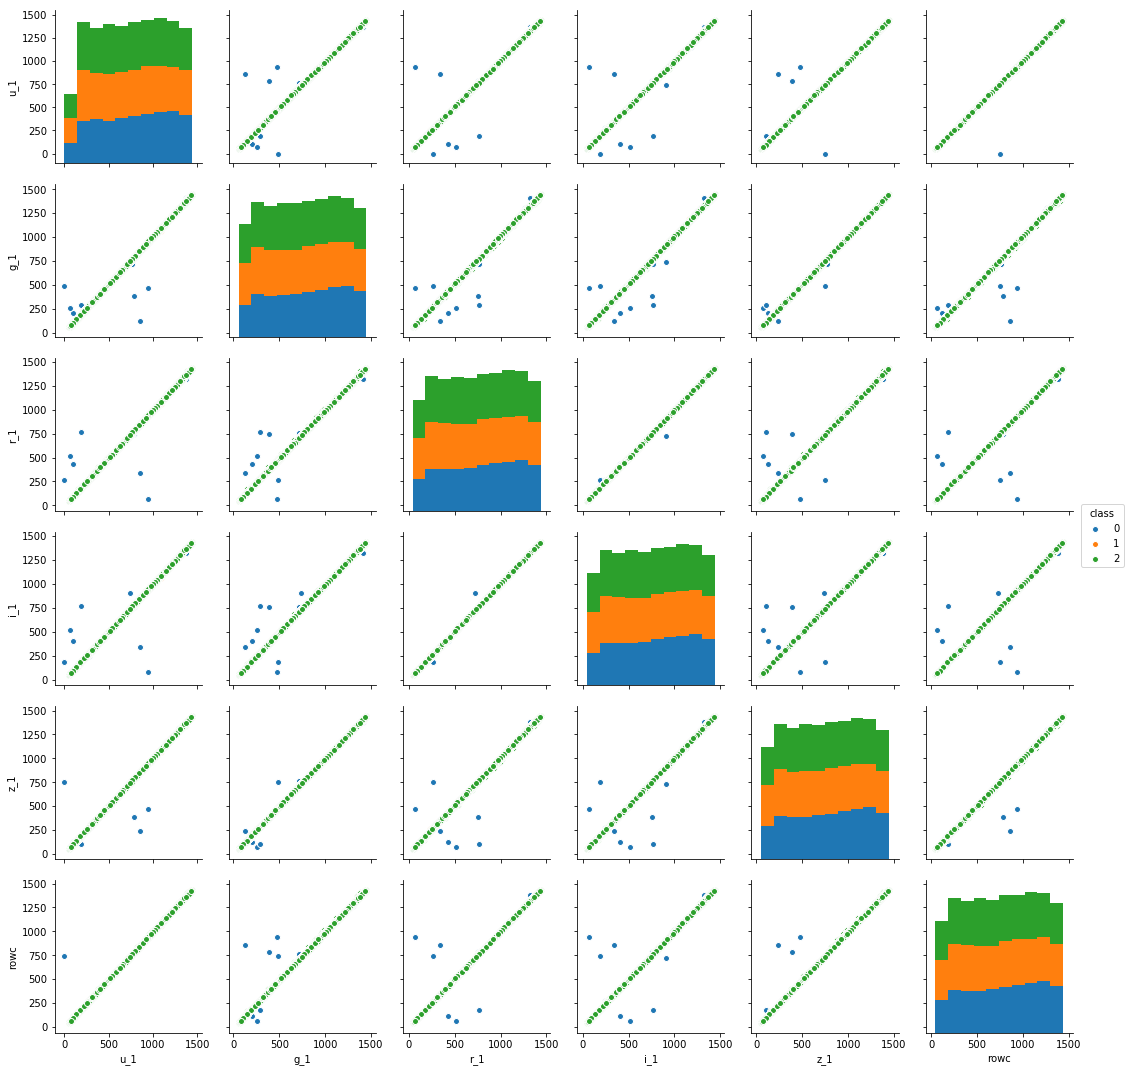

In [25]:
f_features = ["{}_1".format(b) for b in bands_all]
f_features.append('rowc')

group = train[[*f_features, 'class']]
sns.pairplot(group, hue='class', vars=f_features)


Perfect matching)  
Let's check another group

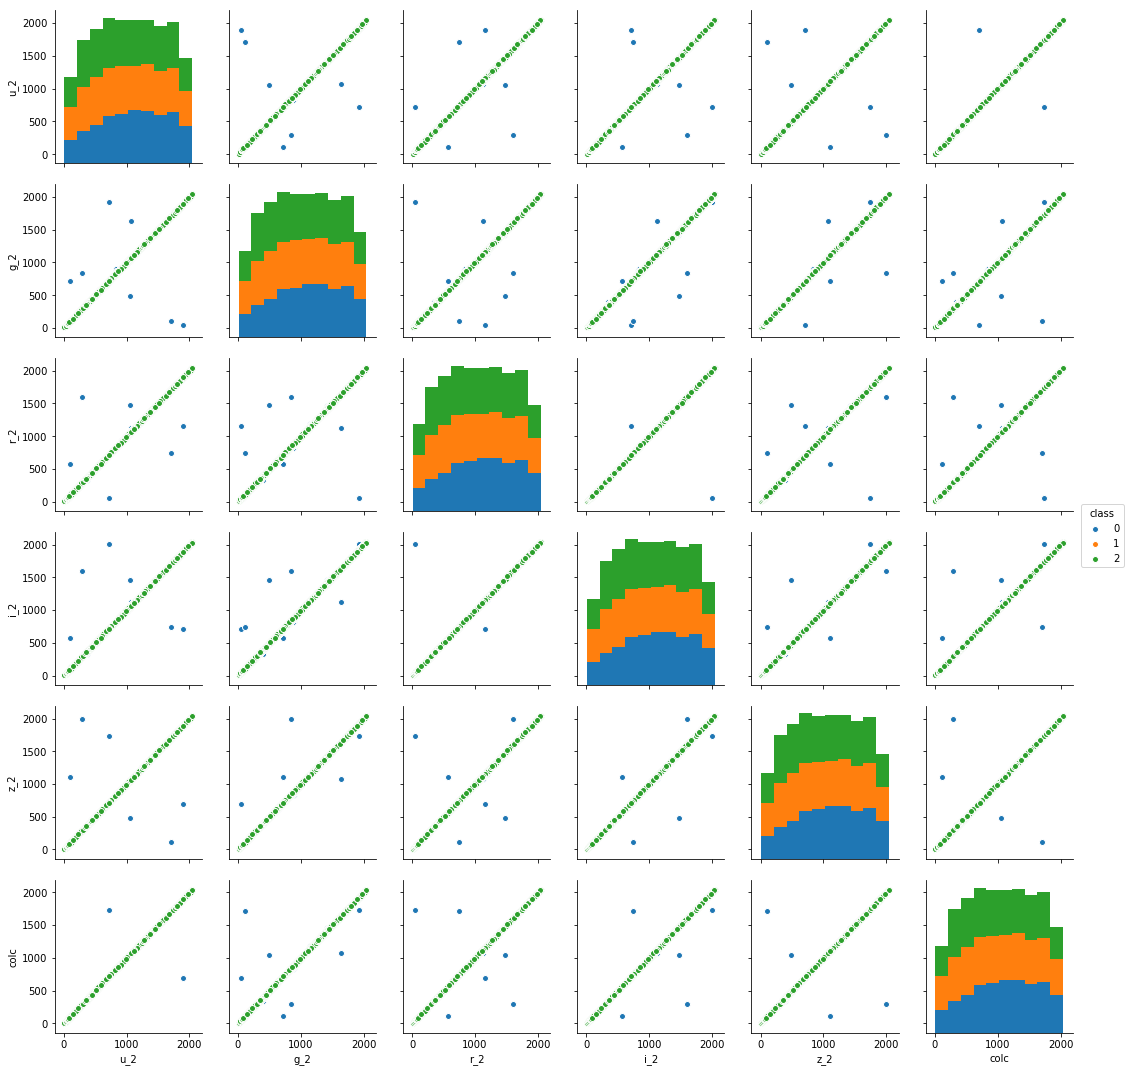

In [26]:
f_features = ["{}_2".format(b) for b in bands_all]
f_features.append('colc')

group = train[[*f_features, 'class']]
sns.pairplot(group, hue='class', vars=f_features)

Since features in each group are highly correlated, and different class samples are evenly distributed though values let's keep only one feature from each group.

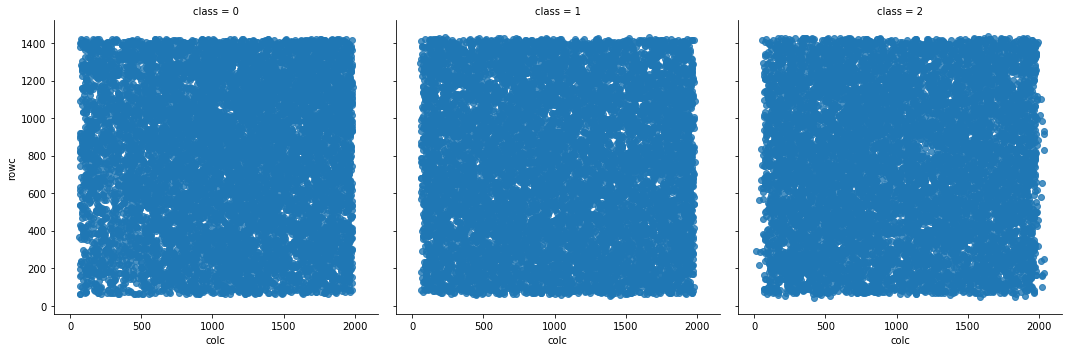

In [27]:
sns.lmplot(x='colc', y='rowc', data=train, col='class', fit_reg=False)

Values of features are evenly distributed in range [0, 2000] and [0, 1400], so it's likely coordinates of objects in frame.  
Let's keep 'rowc' and 'colc' columns and drop 1-st and 2-nd features.

#### 6-th color feature

6-th color feature represents categorial data for a photometric measurment.  

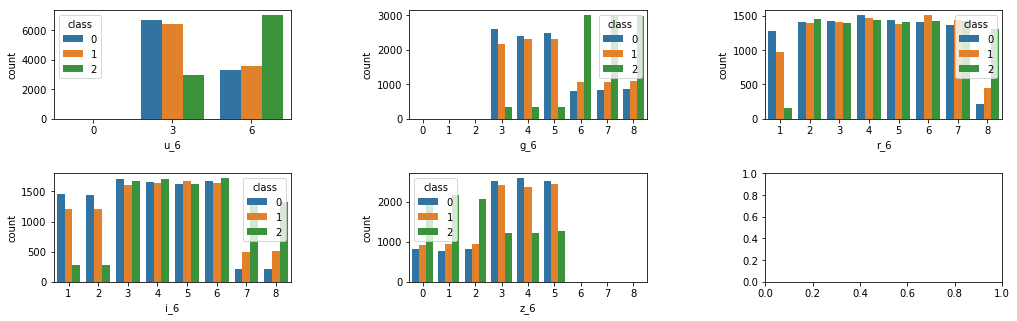

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(17, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, b in enumerate(bands_all):
    f_name = "{}_6".format(b)
    sns.countplot(x=f_name, data=train, ax=ax[i // 3, i % 3], hue='class')

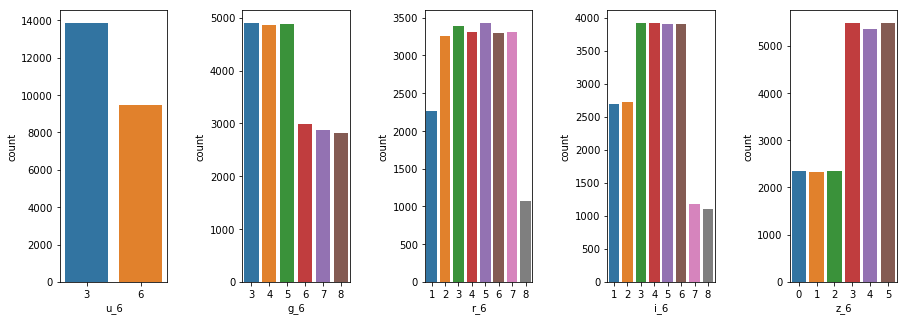

In [29]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.subplots_adjust(wspace=0.7)

for i, b in enumerate(bands_all):
    f_name = "{}_6".format(b)
    sns.countplot(x=f_name, data=unlabeled, ax=ax[i])

In [30]:
for i, b in enumerate(bands_all):
    f_name = "{}_6".format(b)
    print(f_name)
    print(np.sort(train[f_name].unique()))
    print(np.sort(validation[f_name].unique()))
    

u_6
[0 3 6]
[0 3 6]
g_6
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
r_6
[1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
i_6
[1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
z_6
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]


#### 'Clean' column and object in frame characteristics 

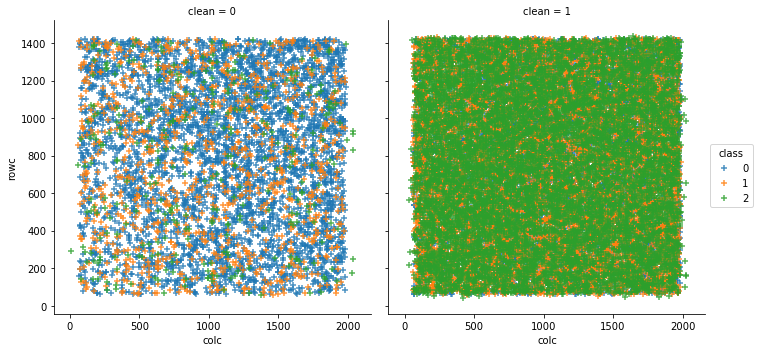

In [15]:
sns.lmplot(x='colc', y='rowc', data=train, col='clean', hue='class', fit_reg=False, markers="+")

clean  class
0      0        3987
       1         959
       2         329
1      2        9671
       1        9041
       0        6013
Name: class, dtype: int64

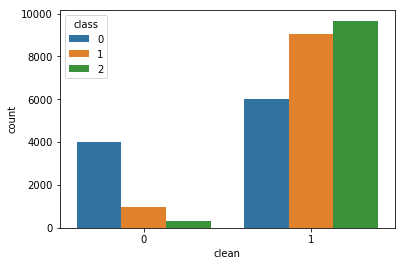

In [34]:
sns.countplot(x='clean', hue='class', data=train)
train.groupby('clean')['class'].value_counts()

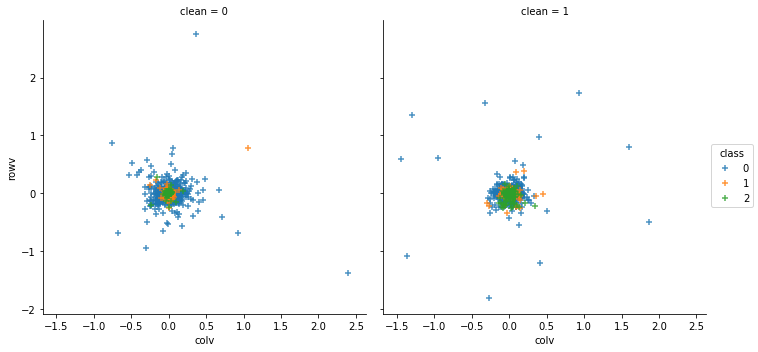

In [21]:
sns.lmplot(x='colv', y='rowv', data=train, hue='class', col='clean', fit_reg=False, markers="+")

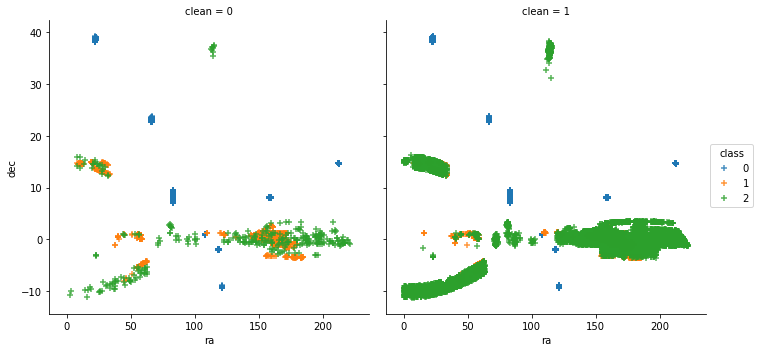

In [23]:
# since ra\dec coordinates in train and validation set are completly different I'm not sure if this is worth checking
sns.lmplot(x='ra', y='dec', data=train, col='clean', hue='class', fit_reg=False, markers="+")

'Cleanliness' of the shot doesn't depend on neither object's velocity in frame nor coordinates of object in frame.  
Elements of 1st class has much more clean shots than 'dirty' ones.  
Element of 0th class and other classes occur in different sky segments in train set. However, test set has completely different values for 'ra' and 'dec' so we can't use this observation.

#### 'ra' and 'dec'

C:\Users\Alina\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Alina\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Alina\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

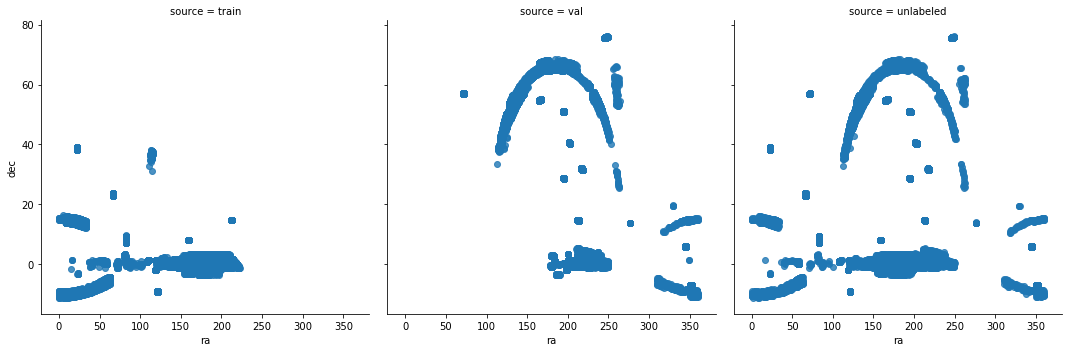

In [25]:
coords = train[['ra', 'dec']]
coords['source'] = 'train'

coords_te = validation[['ra', 'dec']]
coords_te['source'] = 'val'

coords_un = unlabeled[['ra', 'dec']]
coords_un['source'] = 'unlabeled'

coords = coords.append(coords_te)
coords = coords.append(coords_un)

sns.lmplot(x='ra', y='dec', data=coords, col='source', fit_reg=False)

### Conclusion  
  * 3-rd features, 'colv' and 'rowv' columns have much more missing values for 0-th class, compared to others
  * 3-rd, 4-th and 5-th features are probably not usefull: a lot of missing values, outliers and nearly the same values for different classes
  * Outliers in 3-rd, 4-th and 5-th features are not caused by 'dirty' shots and happen more often in elements of 0-th class    
  * 0-th feature may be usefull, but has a lot of missing values. There is a chance to predict NaNs from present 0-th features
  * 1-st and 2-nd features are perfectly correlated (pearsons_r = 1) with 'rowc' and 'colc'
  * Samples of 1-st and 2-nd class are more likely to be captured in clean shot
  * Train and vaidation sets has completely different ranges for 'ra' and 'dec' features
  * Unlabeled set has samples from both train and test sky segments, so it may be reasonable to fill NaNs using unlabeled dataset

## New features

is_smth_missing columns

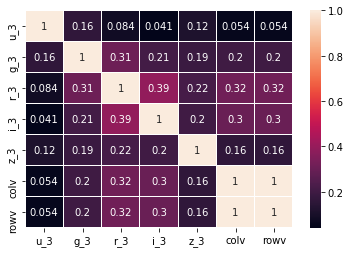

In [26]:
# features with NaN values
features = ["{}_3".format(b) for b in bands_all]
features.extend(['colv', 'rowv'])

is_na_df = train[features].isna().astype('int64')

corr_matrix = is_na_df.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=0.1)

'Colv' and 'Rowv' are strongly correlated, so leave only 'colv'  
'Colv' has ~0 importance in resulting classifier, so drop it too

In [27]:
def get_is_na_columns(data):
    features = ["{}_3".format(b) for b in bands_all]

    is_na_df = data[features].isna().astype('int64')

    # rename columns 
    renamed_features = dict((f, f + "_na") for f in features)
    is_na_df.rename(columns=renamed_features, inplace=True)
    
    return is_na_df

In [28]:
train = pd.concat([train, get_is_na_columns(train)], axis=1)
validation = pd.concat([validation, get_is_na_columns(validation)], axis=1)
unlabeled = pd.concat([unlabeled, get_is_na_columns(unlabeled)], axis=1)

## Missing values

In [29]:
show_missing_values()

,train,validation,unlabeled
u_0,4556,3455,0
g_0,4504,3460,0
r_0,4555,3380,0
i_0,4596,3449,0
z_0,4481,3499,0
rowv,401,681,621
colv,401,681,621
u_3,5173,4836,4935
g_3,1720,1690,1760
r_3,727,752,778


Unlabeled data has less missing values then training and validation sets.  
Columns '-0', '-3', '-4', '-5' in training set has ~13-15% missing values.  
  
  As I said before, let's try to predict 0-th features from present 0-th features 

#### 0-th feature

Check how many 0-th features are missing at the same time in train dataset

0    13266
1    11664
2     4248
3      764
4       50
5        8
dtype: int64


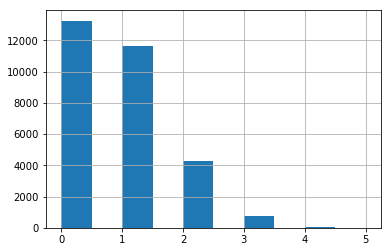

In [30]:
zeros_features = ["{}_0".format(b) for b in bands_all]
num_of_missing_0th = train[zeros_features].isna().sum(axis=1)

print(num_of_missing_0th.value_counts())
num_of_missing_0th.hist()

A few samples have all 0-th features missing, so apply 'regression' prediction  and then fill remaining NaNs with mean values.

In [84]:
train[zeros_features].corr()

,u_0,g_0,r_0,i_0,z_0
u_0,1.000000,0.817264,0.717657,0.631143,0.617691
g_0,0.817264,1.000000,0.901610,0.816336,0.782590
r_0,0.717657,0.901610,1.000000,0.931553,0.873073
i_0,0.631143,0.816336,0.931553,1.000000,0.896410
z_0,0.617691,0.782590,0.873073,0.896410,1.000000


In [85]:
unlabeled[zeros_features].corr()

,u_0,g_0,r_0,i_0,z_0
u_0,1.000000,0.775498,0.682887,0.605890,0.590848
g_0,0.775498,1.000000,0.898527,0.816628,0.768118
r_0,0.682887,0.898527,1.000000,0.915039,0.853865
i_0,0.605890,0.816628,0.915039,1.000000,0.866295
z_0,0.590848,0.768118,0.853865,0.866295,1.000000


Prediction of every feature should be based on the most correlated variable on each step:  
  Example: step 1:
* u_0 based on g_0  
* g_0 based on r_0  
* r_0 based on i_0  
* i_0 based on r_0  
* z_0 based on i_0  

In [40]:
def fill_nans_based_on_regression(col, based_on_col, data):
    print("\n{} based on {}".format(col, based_on_col))
    
    # get only notna values to train regression
    clean_columns_mask = unlabeled[[col, based_on_col]].notna().all(axis=1)
    clean_columns = unlabeled[clean_columns_mask][[col, based_on_col]]
    
    # get samples where 'col' is NaN and 'based_col' is not NaN
    # (samples, where 'col' value will be predicted)
    col_nan_mask = data[col].isna()
    based_col_notna_mask = data[based_on_col].notna()
    samples_to_predict = data[col_nan_mask & based_col_notna_mask]
    
    # reshape to fit the regression
    X = clean_columns[based_on_col].values.reshape(-1, 1)
    y = clean_columns[col].values.reshape(-1, 1)
    to_predict = samples_to_predict[based_on_col].values.reshape(-1, 1)
    
    if len(to_predict):
        reg = LinearRegression()
        reg.fit(X, y)
        print("reg score: {}".format(reg.score(X, y)))

        predicted = reg.predict(to_predict).flatten()

        num_of_nans_before = data[col].isna().sum()

        # fill predicted values instead of NaNs
        idx = samples_to_predict.index
        data.loc[idx, col] = predicted

        num_of_nans_after = data[col].isna().sum()
        print("replaced {} NaN values".format(num_of_nans_before - num_of_nans_after))

In [41]:
def apply_replacement(order):
    for i in range(4):
        print("\n Step {}".format(i + 1))
        replacement_scheme = []
        
        for f in zeros_features:
            base_col = order[f][i]
            replacement_scheme.append((f, base_col))

        for col, based_on_col in replacement_scheme:
            fill_nans_based_on_regression(col, based_on_col, train)

        for col, based_on_col in replacement_scheme:
            fill_nans_based_on_regression(col, based_on_col, validation)

In [42]:
# determine the order of applying regression: order features by correlation strength
corr_matrix = train[zeros_features].corr()
order = {}
for f in zeros_features:
    features_order = corr_matrix[f].argsort()[-2::-1].values
    order[f] = [zeros_features[i] for i in features_order]
            
print(order)

{'i_0': ['r_0', 'z_0', 'g_0', 'u_0'], 'u_0': ['g_0', 'r_0', 'i_0', 'z_0'], 'z_0': ['i_0', 'r_0', 'g_0', 'u_0'], 'g_0': ['r_0', 'u_0', 'i_0', 'z_0'], 'r_0': ['i_0', 'g_0', 'z_0', 'u_0']}


In [43]:
apply_replacement(order)


 Step 1

u_0 based on g_0
reg score: 0.6013977727527016
replaced 3897 NaN values

g_0 based on r_0
reg score: 0.8073505382901713
replaced 3806 NaN values

r_0 based on i_0
reg score: 0.8372954923464588
replaced 3885 NaN values

i_0 based on r_0
reg score: 0.8372954923464588
replaced 3926 NaN values

z_0 based on i_0
reg score: 0.7504671194252449
replaced 4377 NaN values

u_0 based on g_0
reg score: 0.6013977727527016
replaced 2942 NaN values

g_0 based on r_0
reg score: 0.8073505382901713
replaced 2931 NaN values

r_0 based on i_0
reg score: 0.8372954923464588
replaced 2854 NaN values

i_0 based on r_0
reg score: 0.8372954923464588
replaced 2923 NaN values

z_0 based on i_0
reg score: 0.7504671194252449
replaced 3416 NaN values

 Step 2

u_0 based on r_0
reg score: 0.46633521018188473
replaced 643 NaN values

g_0 based on u_0
reg score: 0.6013977727527016
replaced 682 NaN values

r_0 based on g_0
reg score: 0.8073505382901713
replaced 654 NaN values

i_0 based on z_0
reg score: 0.7504

In [44]:
show_missing_values()

,train,validation,unlabeled
u_0,8,12,0
g_0,8,12,0
r_0,8,12,0
i_0,8,12,0
z_0,8,12,0
rowv,401,681,621
colv,401,681,621
u_3,5173,4836,4935
g_3,1720,1690,1760
r_3,727,752,778


Fill all the rest 0-th features with mean values by columns

In [45]:
train[zeros_features] = train[zeros_features].fillna(train[zeros_features].mean())
validation[zeros_features] = validation[zeros_features].fillna(validation[zeros_features].mean())

train[zeros_features].isna().sum().max(), validation[zeros_features].isna().sum().max() 

(0, 0)

#### 3-rd, 4-th and 5-th features

In [46]:
# just fill nans with median value
bands = ['u', 'g', 'r', 'i', 'z']
indx = ['3', '4', '5']
columns_to_fill = ["{}_{}".format(b, i) for b in bands for i in indx]

train[columns_to_fill] = train[columns_to_fill].fillna(train[columns_to_fill].median())
validation[columns_to_fill] = validation[columns_to_fill].fillna(validation[columns_to_fill].median())
unlabeled[columns_to_fill] = unlabeled[columns_to_fill].fillna(unlabeled[columns_to_fill].median())

train[columns_to_fill].isna().sum().max(), validation[columns_to_fill].isna().sum().max() 

(0, 0)

#### colv and rowv features

For now we have only 'rowv' and 'colv' missing values  

In [93]:
show_missing_values()

,train,validation,unlabeled
rowv,401,681,621
colv,401,681,621


In [35]:
train[['rowv', 'colv']].isna().all(axis=1).value_counts()

False    29599
True       401
dtype: int64

In [36]:
unlabeled[['rowv', 'colv']].isna().all(axis=1).value_counts()

False    22712
True       621
dtype: int64

In [37]:
validation[['rowv', 'colv']].isna().all(axis=1).value_counts()

False    22652
True       681
dtype: int64

Columns are both missing or both present   
       
Fill with mean values

In [47]:
train.fillna(train.mean(), inplace=True)
validation.fillna(validation.mean(), inplace=True)
unlabeled.fillna(unlabeled.mean(), inplace=True)

In [48]:
train.isna().sum().max(), validation.isna().sum().max()

(0, 0)

In [49]:
train.shape, validation.shape

((30000, 49), (23333, 49))

### Conclusion

*  Fill  '-3', '-4', '-5'  columns with median value due to ~13-15% of missing values and ~10-20% outliers
*  Fill '-0' columns with regression results based on present '-0' features
*  Fill all remaining '-0' NaNs with mean values
*  Replace 'rowv' and 'colv' NaNs with mean values

## New features

Stars, galaxies and quasars probably differ in 'brightness', i.g. galaxies are brighter that quasars, quasars are brighter than stars. (or vice versa)   
Consider brightness as a measure how many light observations are above the median for this sample.

In [50]:
def get_above_median_columns_count(df):
    features = ["{}_{}".format(b, str(i)) for i in [0, 3, 4, 5] for b in bands_all]
    is_above_features = ["{}_above".format(f) for f in features]

    means = df[features].median()

    is_above_df = pd.DataFrame(columns=is_above_features)
    for f, is_above_f in zip(features, is_above_features):
        is_above_df[is_above_f] = df[f] > means[f]

    # sum is_above by measurement (0-th, 3-rd, 4-th and 5-th features)
    num_of_above_columns = ['0th_above', '3rd_above', '4th_above', '5th_above']
    num_of_above = pd.DataFrame(columns=num_of_above_columns)
    for idx, f_name in zip([0, 5, 10, 15], num_of_above_columns): 
        num_of_above[f_name] = is_above_df.iloc[:, idx:idx+5].sum(axis=1)
    return num_of_above


In [51]:
train_aboves  = get_above_median_columns_count(train)
temp = pd.concat([train, train_aboves], axis=1)

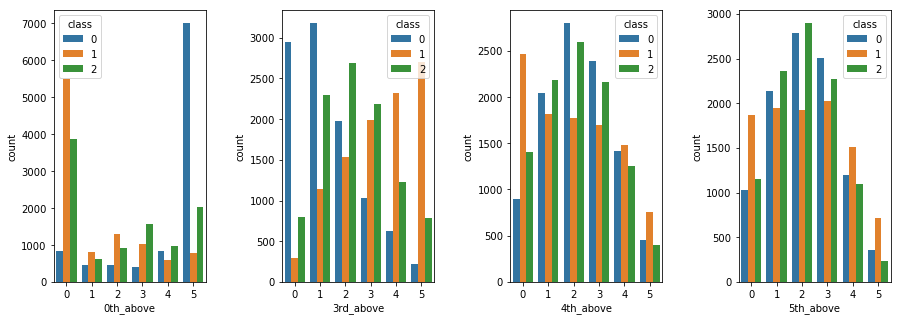

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
plt.subplots_adjust(wspace=0.5)

for i, f_name in enumerate(train_aboves.columns):
    sns.countplot(x=f_name, data=temp, hue='class', ax=ax[i])

*3rd_above* seems to be the most informative. 

In [53]:
train = pd.concat([train, get_above_median_columns_count(train)], axis=1)
validation = pd.concat([validation, get_above_median_columns_count(validation)], axis=1)

## Data preparation

#### drop not relevant features

In [54]:
# eventually delete 1-st and 2-nd features, 'colc', 'rowc' 
bands = ['u', 'g', 'r', 'i', 'z']
indx = ['1', '2']
columns_to_drop = ["{}_{}".format(b, i) for b in bands for i in indx]
columns_to_drop.extend(['colc', 'rowc'])


train = train.drop(columns_to_drop, axis=1)
validation = validation.drop(columns_to_drop, axis=1)

unlabeled = unlabeled.drop(columns_to_drop, axis=1)

#### 6-th color feature 

In [60]:
# '-6' are categorical variables and need to be converted

features = ["{}_6".format(b) for b in bands_all]

dummy_train = pd.DataFrame()
dummy_val = pd.DataFrame()
for f in features:   
    dummy_train = pd.concat([dummy_train, pd.get_dummies(train[f], prefix=f)], axis=1)    
    dummy_val = pd.concat([dummy_val, pd.get_dummies(validation[f], prefix=f)], axis=1)

# in case test set has values train set doesn't have
values = ["{}_{}".format(f, i) for f in features for i in range(9)]

dummy_train = dummy_train.reindex(columns=values).fillna(0).astype('int64')
dummy_val = dummy_val.reindex(columns=values).fillna(0).astype('int64')

train = pd.concat([train, dummy_train], axis=1)
validation = pd.concat([validation, dummy_val], axis=1)

# drop initial categorical variables
train.drop(features, axis=1, inplace=True)
validation.drop(features, axis=1, inplace=True)

#### 'ra' & 'dec'

'ra' and 'dec' features have completly different ranges in train and validation-test sets

In [56]:
train.drop(['ra', 'dec'], axis=1, inplace=True)
validation.drop(['ra', 'dec'], axis=1, inplace=True)

In [61]:
train.shape, validation.shape

((30000, 111), (23333, 111))

In [62]:
train.columns

Index(['objid', 'u_0', 'g_0', 'r_0', 'i_0', 'z_0', 'clean', 'rowv', 'colv',
       'u_3',
       ...
       '4th_above_8', '5th_above_0', '5th_above_1', '5th_above_2',
       '5th_above_3', '5th_above_4', '5th_above_5', '5th_above_6',
       '5th_above_7', '5th_above_8'],
      dtype='object', length=111)

Save clean and prepared data for later.

In [59]:
train.to_csv("data/train_clean.csv", index=False)
validation.to_csv("data/validation_clean.csv", index=False)

# Prediction

In [83]:
train = pd.read_csv("data/train_clean.csv")
validation = pd.read_csv("data/validation_clean.csv")

In [65]:
validation['class'].value_counts()

0    13333
2     5000
1     5000
Name: class, dtype: int64

In [84]:
columns_to_drop = ['objid', 'class']

X_train = train.drop(columns_to_drop, axis=1)
y_train = train['class']

X_test = validation.drop(columns_to_drop, axis=1)
y_test = validation['class']

colummn_names = X_train.columns

In [70]:
do_plot=False

def try_classifier(clf, params=None):
    if not params is None:
        print(params)
        clf.set_params(**params)
    start = time.time()
    
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    
    end = time.time()
    print("{0:.2f} sec".format((end - start)))
    
    print("f1-score: {}".format(f1_score(y_test, prediction, average='macro')))
    
    if do_plot:
        cm = confusion_matrix(y_test, prediction)
        sns.heatmap(cm, annot=True, fmt="d")
        plt.show()
    

In [54]:
def try_with_all_classifiers():
    print("Decision Tree classifier: ")
    try_classifier(DecisionTreeClassifier())
    try_classifier(DecisionTreeClassifier(), {"min_samples_split": 270})
    
    print("\nLogistic Regression: ")
    #try_classifier(LogisticRegression())
    #try_classifier(LogisticRegression(), {'multi_class': 'multinomial', 'solver': 'newton-cg', 'max_iter': 100})
    
    print("\nRandom Forest classifier: ")
    try_classifier(RandomForestClassifier())
    try_classifier(RandomForestClassifier(), {"min_samples_split": 2, "n_estimators": 150})
    
    print("\nAdaBoostClassifier: ")
    try_classifier(AdaBoostClassifier(), {'n_estimators': 50, 
                                          'learning_rate': 0.01, 
                                          'base_estimator': DecisionTreeClassifier(min_samples_split=10)})

Decision Tree classifier: 
2.05 sec
f1-score: 0.7528337319073434


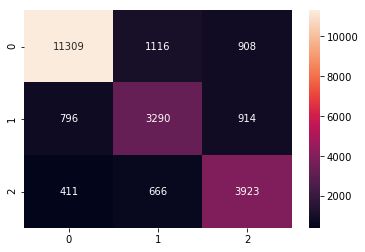

{'min_samples_split': 270}
1.64 sec
f1-score: 0.8156803140229885


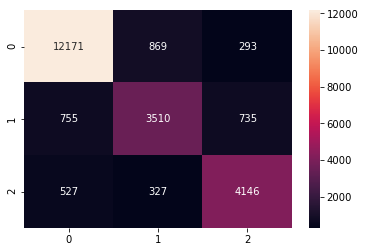


Logistic Regression: 

Random Forest classifier: 
2.03 sec
f1-score: 0.8188115398240078


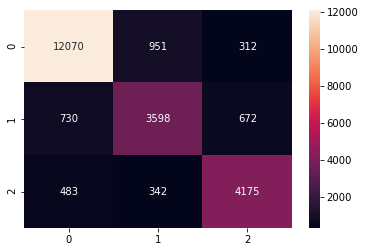

{'min_samples_split': 2, 'n_estimators': 150}
18.71 sec
f1-score: 0.8444301309695882


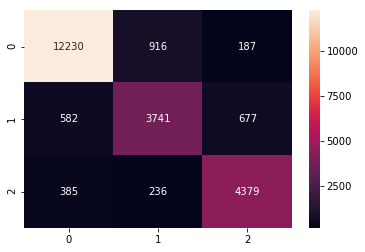


AdaBoostClassifier: 
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'learning_rate': 0.01, 'n_estimators': 50}
99.02 sec
f1-score: 0.8460272804943457


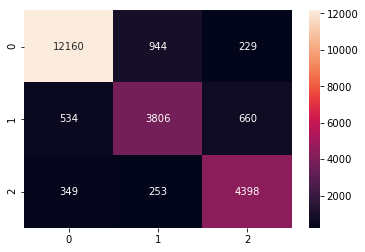

In [243]:
try_with_all_classifiers()

In [244]:
# try scalling data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Decision Tree classifier: 
2.24 sec
f1-score: 0.7521262776253085


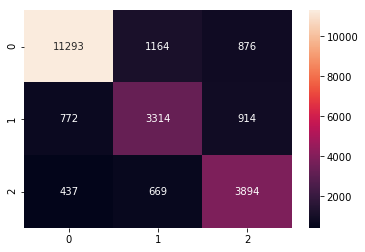

{'min_samples_split': 270}
2.54 sec
f1-score: 0.8154958030663683


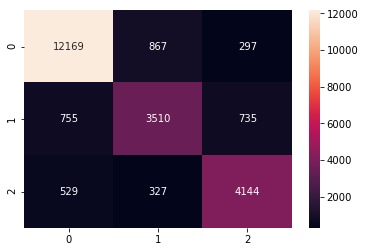


Logistic Regression: 

Random Forest classifier: 
2.52 sec
f1-score: 0.8258721722859113


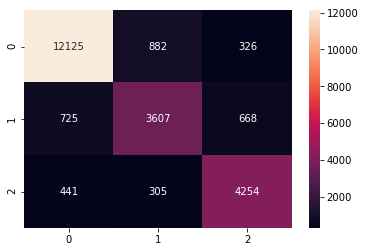

{'min_samples_split': 2, 'n_estimators': 150}
22.69 sec
f1-score: 0.8445399617619479


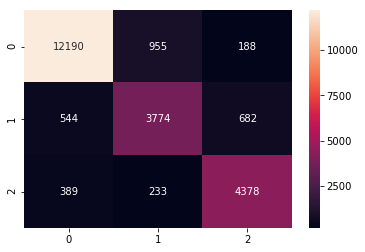


AdaBoostClassifier: 
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'learning_rate': 0.01, 'n_estimators': 50}
91.99 sec
f1-score: 0.8475557124522687


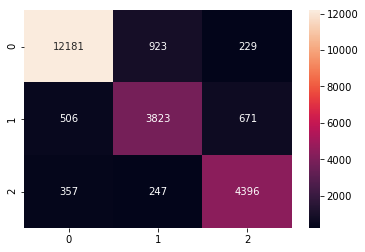

In [245]:
try_with_all_classifiers()

In [246]:
# determine most important features

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

for i, idx in enumerate(indices):
    print("{}: {} {}".format(i, colummn_names[idx], importances[idx]))

0: z_0 0.1043949225536844
1: i_0 0.08527156057590862
2: r_0 0.07511286523935704
3: g_0 0.06816033532316737
4: u_0 0.06496506261856955
5: r_3 0.04650728971843031
6: g_3 0.0358004095295148
7: i_3 0.03536888752354282
8: 0th_above 0.03189990551901649
9: u_6_6 0.031103752619067986
10: u_3 0.028075340859979668
11: g_4 0.021306770370324062
12: z_3 0.020717223663935518
13: clean 0.020151470146705222
14: g_5 0.018648618342898833
15: u_5 0.0181207182713402
16: colv 0.018022943028771554
17: r_4 0.01779956051402229
18: r_5 0.017750459188543323
19: i_5 0.017389420395799875
20: rowv 0.016510065292013036
21: i_4 0.015744538858700245
22: z_5 0.014989910886185981
23: colc 0.014458208045946575
24: u_4 0.01400407739767873
25: z_4 0.013103830446077314
26: rowc 0.012831377854235406
27: g_6_3 0.012089594645815544
28: g_6_5 0.011424744218826824
29: 3rd_above 0.008472048420298774
30: u_3_na 0.00803586500147984
31: 4th_above 0.00700341681963261
32: g_6_4 0.006938782110350787
33: g_6_6 0.006017062412796396
34: 

In [265]:
# leave only 'important' features
important_columns = X_train.columns[importances > 0]

X_train = X_train.reindex(columns=important_columns)
X_test = X_test.reindex(columns=important_columns)

Decision Tree classifier: 
1.15 sec
f1-score: 0.7396989346282857


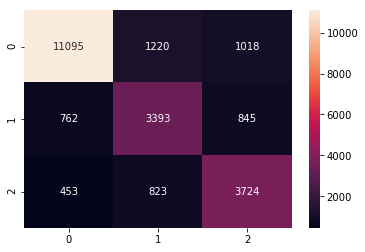

{'min_samples_split': 270}
1.34 sec
f1-score: 0.8000519435909995


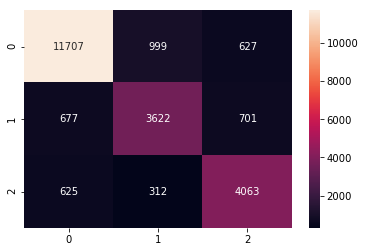


Logistic Regression: 

Random Forest classifier: 
2.73 sec
f1-score: 0.8165135302507469


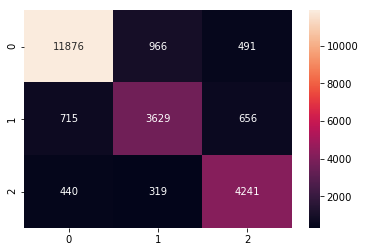

{'min_samples_split': 2, 'n_estimators': 150}
26.35 sec
f1-score: 0.8431523913843509


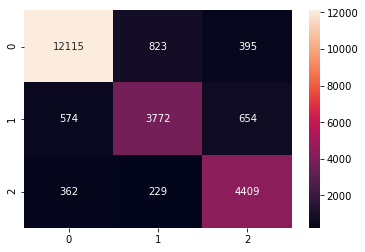


AdaBoostClassifier: 
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'learning_rate': 0.01, 'n_estimators': 50}
50.33 sec
f1-score: 0.8435253495179026


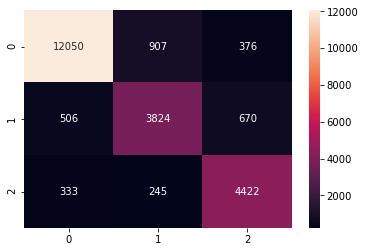

In [266]:
try_with_all_classifiers()

### Playground

#### Decision tree

2.21 sec
f1-score: 0.7540049602414776


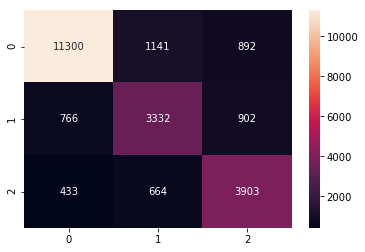

In [77]:
try_classifier(DecisionTreeClassifier())

In [69]:
# ~250-300  ~81%
params = {
    "min_samples_split": [100, 150, 200, 230, 250, 270, 300, 350, 400, 500]
}

grid = ParameterGrid(params)

for ps in grid:
    try_classifier(DecisionTreeClassifier(), ps)

{'min_samples_split': 100}
2.27 sec
f1-score: 0.8113569134231454
{'min_samples_split': 150}
1.48 sec
f1-score: 0.8192314981954247
{'min_samples_split': 200}
1.75 sec
f1-score: 0.8177583583119503
{'min_samples_split': 230}
2.02 sec
f1-score: 0.8167909715285576
{'min_samples_split': 250}
1.47 sec
f1-score: 0.8178542498998774
{'min_samples_split': 270}
1.38 sec
f1-score: 0.8174840852986064
{'min_samples_split': 300}
2.11 sec
f1-score: 0.815317791765862
{'min_samples_split': 350}
1.35 sec
f1-score: 0.8194068955024859
{'min_samples_split': 400}
1.92 sec
f1-score: 0.8192944087272623
{'min_samples_split': 500}
1.24 sec
f1-score: 0.8209653998674097


#### KNeighbours

28.03 sec
f1-score: 0.375765176708501


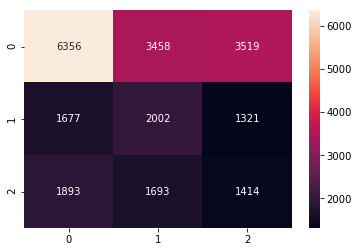

In [78]:
try_classifier(KNeighborsClassifier())

#### Logistic Regression

8.40 sec
f1-score: 0.699732838793333


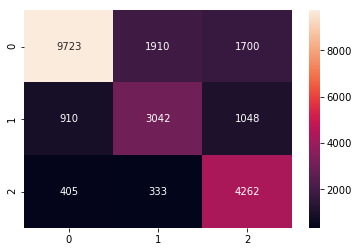

In [79]:
try_classifier(LogisticRegression())

In [70]:
params = [
    {'multi_class': ['multinomial', 'ovr'], 'solver': ['lbfgs', 'sag', 'newton-cg']},
    {'multi_class': ['ovr'], 'solver': ['liblinear'], 'penalty': ['l1', 'l2']}
]

grid = ParameterGrid(params)

for ps in grid:
    try_classifier(LogisticRegression(), ps)

{'solver': 'lbfgs', 'multi_class': 'multinomial'}
1.99 sec
f1-score: 0.6976091009232639
{'solver': 'sag', 'multi_class': 'multinomial'}


C:\Users\Alina\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


6.86 sec
f1-score: 0.6535701031369533
{'solver': 'newton-cg', 'multi_class': 'multinomial'}


C:\Users\Alina\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


70.98 sec
f1-score: 0.79074552472647
{'solver': 'lbfgs', 'multi_class': 'ovr'}
2.02 sec
f1-score: 0.7025609790533988
{'solver': 'sag', 'multi_class': 'ovr'}


C:\Users\Alina\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


11.22 sec
f1-score: 0.6046452451175912
{'solver': 'newton-cg', 'multi_class': 'ovr'}
39.81 sec
f1-score: 0.7808561462225062
{'penalty': 'l1', 'solver': 'liblinear', 'multi_class': 'ovr'}
61.95 sec
f1-score: 0.7808327515030821
{'penalty': 'l2', 'solver': 'liblinear', 'multi_class': 'ovr'}
10.38 sec
f1-score: 0.699732838793333


{'max_iter': 250, 'solver': 'newton-cg', 'multi_class': 'multinomial'}


C:\Users\Alina\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


269.57 sec
f1-score: 0.7907289544329741


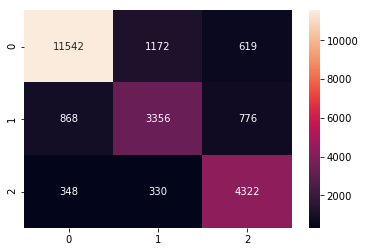

In [80]:
params = {
    'multi_class': 'multinomial',
    'solver': 'newton-cg',
    'max_iter': 250
}

try_classifier(LogisticRegression(), params)

#### Random Forest

In [151]:
# ~84.5%   10 120 gini sqrt  2 120 entropy sqrt
params = {
    "min_samples_split": [2, 10, 25, 50],
    "n_estimators": [10, 50, 100, 120],
    "criterion": ['gini', 'entropy'],
    "max_features": ['sqrt', 'log2']
}

grid = ParameterGrid(params)

for ps in grid:
    try_classifier(RandomForestClassifier(), ps)

{'min_samples_split': 2, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10}
1.51 sec
f1-score: 0.8240335868895542
{'min_samples_split': 2, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 50}
6.76 sec
f1-score: 0.8417287497539799
{'min_samples_split': 2, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
12.70 sec
f1-score: 0.8441672299587131
{'min_samples_split': 2, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 120}
19.82 sec
f1-score: 0.8455664530366183
{'min_samples_split': 10, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10}
1.44 sec
f1-score: 0.8243203497724387
{'min_samples_split': 10, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 50}
6.25 sec
f1-score: 0.8437969507049715
{'min_samples_split': 10, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
16.54 sec
f1-score: 0.8446415973300102
{'min_samples_split': 10, 'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 120}
15.

In [72]:
# ~84.5% : 2 170 gini sqrt  ~84.6 10 170 gini sqrt 
params = {
    "min_samples_split": [2, 10],
    "n_estimators": [50, 100, 120, 150, 170, 200],
    "criterion": ['gini', 'entropy'],
    "max_features": ['sqrt', 'log2']
}

grid = ParameterGrid(params)

for ps in grid:
    try_classifier(RandomForestClassifier(), ps)

{'n_estimators': 50, 'max_features': 'sqrt', 'min_samples_split': 2, 'criterion': 'gini'}
10.20 sec
f1-score: 0.8434981913557298
{'n_estimators': 100, 'max_features': 'sqrt', 'min_samples_split': 2, 'criterion': 'gini'}
20.16 sec
f1-score: 0.8447495849833158
{'n_estimators': 120, 'max_features': 'sqrt', 'min_samples_split': 2, 'criterion': 'gini'}
22.23 sec
f1-score: 0.844492112655956
{'n_estimators': 150, 'max_features': 'sqrt', 'min_samples_split': 2, 'criterion': 'gini'}
20.05 sec
f1-score: 0.8442258190767301
{'n_estimators': 170, 'max_features': 'sqrt', 'min_samples_split': 2, 'criterion': 'gini'}
22.33 sec
f1-score: 0.8454352598450954
{'n_estimators': 200, 'max_features': 'sqrt', 'min_samples_split': 2, 'criterion': 'gini'}
37.00 sec
f1-score: 0.8464786842679978
{'n_estimators': 50, 'max_features': 'sqrt', 'min_samples_split': 10, 'criterion': 'gini'}
10.11 sec
f1-score: 0.8440661525928351
{'n_estimators': 100, 'max_features': 'sqrt', 'min_samples_split': 10, 'criterion': 'gini'}


In [73]:
# no need in very large number of estimators
params = {
    "min_samples_split": [2, 10],
    "n_estimators": [170, 200, 230, 250, 300],
    "criterion": ['gini', 'entropy'],
}

grid = ParameterGrid(params)

for ps in grid:
    try_classifier(RandomForestClassifier(), ps)

{'n_estimators': 170, 'min_samples_split': 2, 'criterion': 'gini'}
21.24 sec
f1-score: 0.8464273971301418
{'n_estimators': 200, 'min_samples_split': 2, 'criterion': 'gini'}
25.53 sec
f1-score: 0.8454117070777665
{'n_estimators': 230, 'min_samples_split': 2, 'criterion': 'gini'}
28.61 sec
f1-score: 0.8462747154362985
{'n_estimators': 250, 'min_samples_split': 2, 'criterion': 'gini'}
31.56 sec
f1-score: 0.846517162427992
{'n_estimators': 300, 'min_samples_split': 2, 'criterion': 'gini'}
37.63 sec
f1-score: 0.8463451801068865
{'n_estimators': 170, 'min_samples_split': 10, 'criterion': 'gini'}
21.13 sec
f1-score: 0.8460460563123204
{'n_estimators': 200, 'min_samples_split': 10, 'criterion': 'gini'}
24.83 sec
f1-score: 0.8465945804035866
{'n_estimators': 230, 'min_samples_split': 10, 'criterion': 'gini'}
27.74 sec
f1-score: 0.8461431679973566
{'n_estimators': 250, 'min_samples_split': 10, 'criterion': 'gini'}
30.18 sec
f1-score: 0.8456957046601401
{'n_estimators': 300, 'min_samples_split': 

{'n_estimators': 150, 'min_samples_split': 10}
25.13 sec
f1-score: 0.8463208650841341


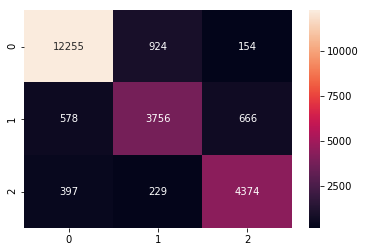

In [81]:
params = {
    "min_samples_split": 10,
    "n_estimators": 150
}

try_classifier(RandomForestClassifier(), params)

#### AdaBoostClassifier

9.39 sec
f1-score: 0.7834426419157544


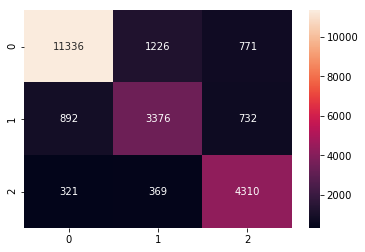

In [82]:
try_classifier(AdaBoostClassifier())

In [275]:
params = {
    'base_estimator': [DecisionTreeClassifier(), DecisionTreeClassifier(min_samples_split=10)],
    'n_estimators': [50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}

grid = ParameterGrid(params)

for ps in grid:
    try_classifier(AdaBoostClassifier(), ps)

{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'learning_rate': 0.001, 'n_estimators': 50}
1.36 sec
f1-score: 0.7387973121641519
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'learning_rate': 0.001, 'n_estimators': 100}
1.08 sec
f1-score: 0.7411303372812427
{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity


{'n_estimators': 200, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'learning_rate': 0.001}
272.8111608028412 sec
0.846701119813


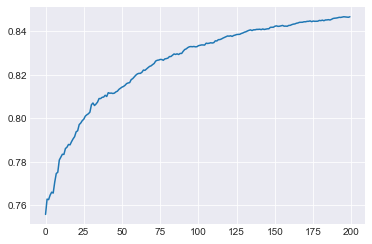

best result: 0.846715826829708 with 195 estimators

{'n_estimators': 200, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'learning_rate': 0.003}
316.1772961616516 sec
0.848638098809


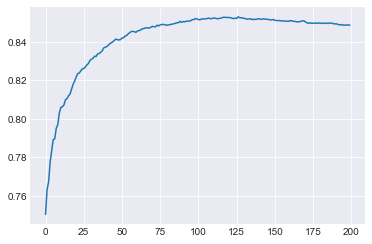

best result: 0.8530243849618445 with 126 estimators

{'n_estimators': 200, 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'learning_rate': 0.005}
365.98592710494995 sec
0.844820912521


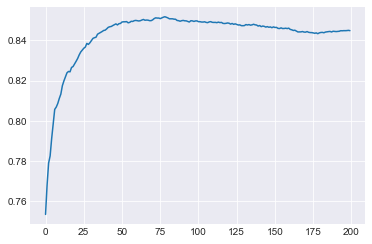

best result: 0.8517228532390969 with 78 estimators


In [148]:
# ~85.0% split=10, lr=0.005, n_est = 80 (120?) 
params = {
    'base_estimator': [DecisionTreeClassifier(min_samples_split=10)], 
#                        DecisionTreeClassifier(min_samples_split=25),
#                        DecisionTreeClassifier(min_samples_split=50),],
    'n_estimators': [200],
    'learning_rate': [0.001, 0.003, 0.005]
}

grid = ParameterGrid(params)

for ps in grid:
    cls = AdaBoostClassifier()
    cls.set_params(**ps)
    print()
    print(ps)
    
    start = time.time()
    cls.fit(X_train, y_train)
    prediction = cls.predict(X_test)
    end = time.time()
    print("{} sec".format(end - start))
    
    print(f1_score(y_test, prediction, average='macro'))
    
    staged_predictions = list(cls.staged_predict(X_test))
    scores = []
    for prediction in staged_predictions:
        scores.append(f1_score(y_test, prediction, average='macro'))
    sns.set_style("darkgrid")
    plt.plot(scores)
    plt.show()
    print("best result: {} with {} estimators".format(np.max(scores), np.argmax(scores)))

{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'learning_rate': 0.005, 'n_estimators': 100}
93.73 sec
f1-score: 0.8439137401535216


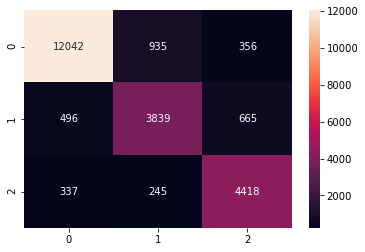

In [267]:
try_classifier(AdaBoostClassifier(), {'n_estimators': 100, 
                                      'learning_rate': 0.005, 
                                      'base_estimator': DecisionTreeClassifier(min_samples_split=10)})

{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'learning_rate': 0.005, 'n_estimators': 150}
142.57 sec
f1-score: 0.8416315728642539


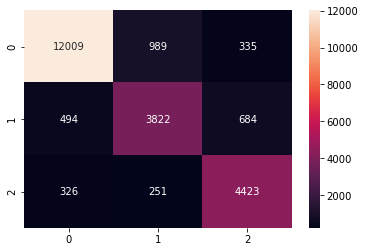

In [268]:
try_classifier(AdaBoostClassifier(), {'n_estimators': 150, 
                                      'learning_rate': 0.005, 
                                      'base_estimator': DecisionTreeClassifier(min_samples_split=10)})

In [73]:
adb_cls = AdaBoostClassifier(n_estimators=120, learning_rate=0.003, 
                             base_estimator=DecisionTreeClassifier(min_samples_split=10))
start = time.time()
adb_cls.fit(X_train, y_train)
end = time.time()
print("{} sec".format(end - start))

204.35308170318604 sec


In [85]:
# try scalling data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [86]:
adb_cls = AdaBoostClassifier(n_estimators=120, learning_rate=0.003, 
                             base_estimator=DecisionTreeClassifier(min_samples_split=10))
start = time.time()
adb_cls.fit(X_train, y_train)
end = time.time()
print("{} sec".format(end - start))

170.1987748146057 sec


In [87]:
prediction = adb_cls.predict(X_test)

In [88]:
f1_score(y_test, prediction, average='macro')

0.85060001269650387

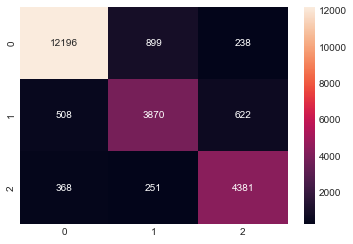

In [89]:
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True, fmt="d")

In [90]:
importances = adb_cls.feature_importances_
indices = np.argsort(importances)[::-1]

for i, idx in enumerate(indices):
    print("{}: {} {}".format(i, colummn_names[idx], importances[idx]))

0: g_0 0.14258650528186995
1: z_0 0.11551825256520985
2: u_0 0.07696668402476757
3: i_0 0.05756633509683166
4: r_0 0.04502269417757229
5: g_3 0.03806169702443818
6: i_3 0.03489033572315149
7: r_3 0.029077262072857768
8: colv 0.028897994391063477
9: r_4 0.02598009637020078
10: u_3 0.02546915190094987
11: rowv 0.02526695336084574
12: g_5 0.02508171912826356
13: z_3 0.024542216420669553
14: i_4 0.022873710441176823
15: g_4 0.0228161462507611
16: r_5 0.022714905509055465
17: z_5 0.02215940508993821
18: u_5 0.022096437262845818
19: i_5 0.02173235085002968
20: u_4 0.021686795366705352
21: z_4 0.019865513618543485
22: g_6_4 0.011691966057872403
23: g_6_5 0.010661234880783686
24: u_6_3 0.00987003193021165
25: g_6_3 0.009698296468284191
26: clean 0.008622929912578207
27: u_6_6 0.006761766103498686
28: 4th_above 0.0052851769837648525
29: 5th_above 0.004624944120098487
30: 3rd_above 0.004353627275537619
31: g_6_8 0.003980260012660493
32: g_6_6 0.003684333250842549
33: g_6_7 0.00298821697397965
34

In [344]:
# leave only 'important' features
important_columns = X_train.columns[importances > 10 ** -4]

X_train = X_train.reindex(columns=important_columns)
X_test = X_test.reindex(columns=important_columns)

In [91]:
staged_predictions = adb_cls.staged_predict(X_test)
scores = []
for prediction in staged_predictions:
    scores.append(f1_score(y_test, prediction, average='macro'))

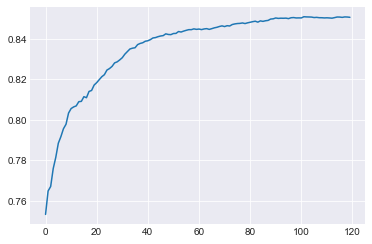

In [92]:
sns.set_style("darkgrid")
plt.plot(scores)

In [93]:
print(np.max(scores), np.argmax(scores))

0.850879429053 101


#### Gradient Boosting Classifier

In [364]:
gb_cls = GradientBoostingClassifier()

start = time.time()
gb_cls.fit(X_train, y_train)
end = time.time()
print("{} sec".format(end - start))

prediction = gb_cls.predict(X_test)
print(f1_score(y_test, prediction, average='macro'))

0.832221838135


In [365]:
scores = []
staged_predictions = gb_cls.staged_predict(X_test)

for prediction in staged_predictions:
    scores.append(f1_score(y_test, prediction, average='macro'))

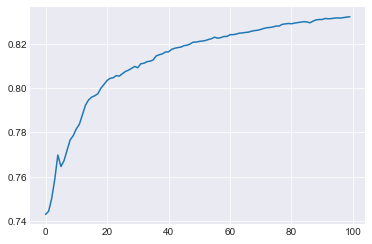

In [366]:
sns.set_style("darkgrid")
plt.plot(scores)

In [367]:
print(np.max(scores), np.argmax(scores))

0.832221838135 99



{'min_samples_split': 2, 'learning_rate': 0.001, 'n_estimators': 300}
106.77502250671387 sec
0.751128306279


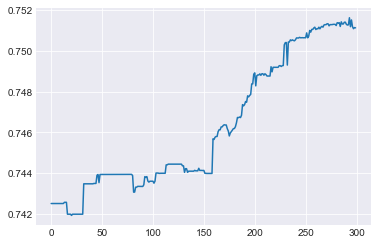

best result: 0.7516236229087746 with 293 estimators

{'min_samples_split': 10, 'learning_rate': 0.001, 'n_estimators': 300}
107.20575833320618 sec
0.751128306279


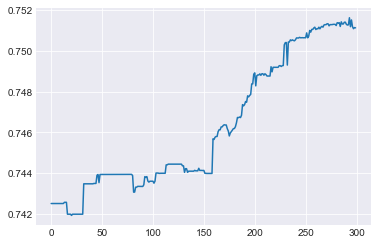

best result: 0.7516236229087746 with 293 estimators

{'min_samples_split': 25, 'learning_rate': 0.001, 'n_estimators': 300}
107.10579991340637 sec
0.751128306279


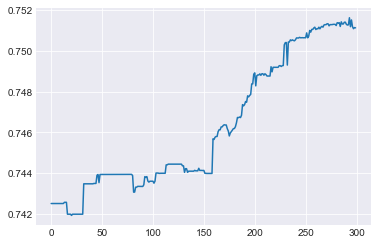

best result: 0.7516236229087746 with 293 estimators

{'min_samples_split': 2, 'learning_rate': 0.005, 'n_estimators': 300}
111.72817587852478 sec
0.793588539017


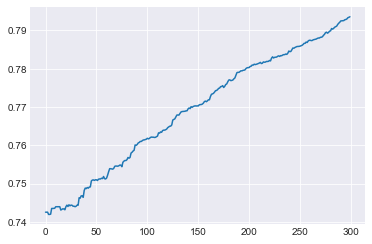

best result: 0.7935885390172553 with 299 estimators

{'min_samples_split': 10, 'learning_rate': 0.005, 'n_estimators': 300}
109.27659463882446 sec
0.793588539017


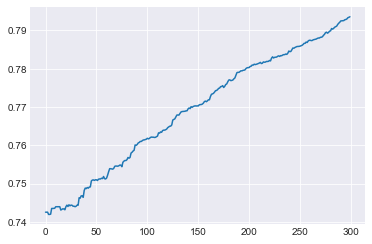

best result: 0.7935885390172553 with 299 estimators

{'min_samples_split': 25, 'learning_rate': 0.005, 'n_estimators': 300}
106.68605613708496 sec
0.793588539017


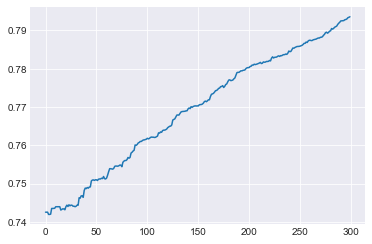

best result: 0.7935885390172553 with 299 estimators

{'min_samples_split': 2, 'learning_rate': 0.01, 'n_estimators': 300}
105.5267186164856 sec
0.809442680696


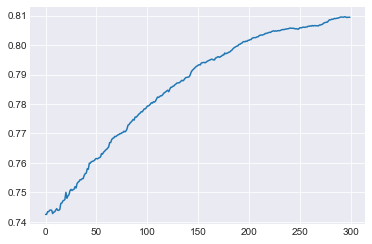

best result: 0.8096033242225885 with 294 estimators

{'min_samples_split': 10, 'learning_rate': 0.01, 'n_estimators': 300}
104.24345588684082 sec
0.809442680696


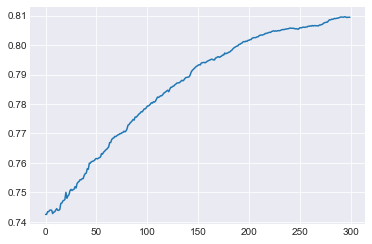

best result: 0.8096033242225885 with 294 estimators

{'min_samples_split': 25, 'learning_rate': 0.01, 'n_estimators': 300}
133.33283472061157 sec
0.809507906226


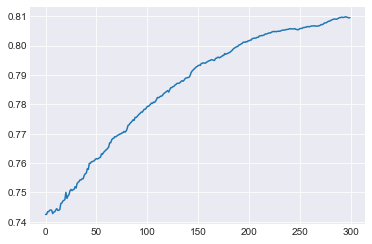

best result: 0.8098109969889493 with 295 estimators

{'min_samples_split': 2, 'learning_rate': 0.05, 'n_estimators': 300}
123.89422607421875 sec
0.83577091218


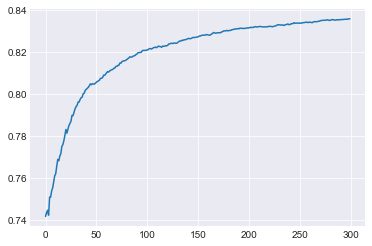

best result: 0.8357709121804152 with 299 estimators

{'min_samples_split': 10, 'learning_rate': 0.05, 'n_estimators': 300}
115.12685179710388 sec
0.835288563315


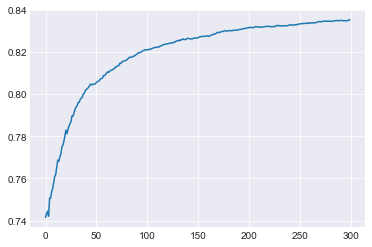

best result: 0.8352885633151658 with 299 estimators

{'min_samples_split': 25, 'learning_rate': 0.05, 'n_estimators': 300}
128.69057750701904 sec
0.834395936474


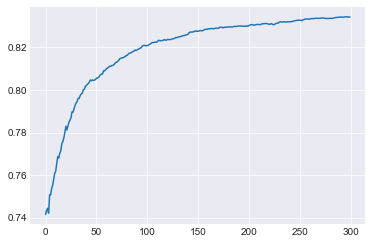

best result: 0.8344613636972588 with 295 estimators

{'min_samples_split': 2, 'learning_rate': 0.1, 'n_estimators': 300}
114.16855192184448 sec
0.839723203626


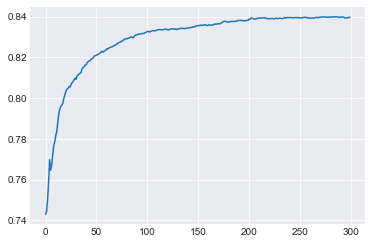

best result: 0.839909840599986 with 284 estimators

{'min_samples_split': 10, 'learning_rate': 0.1, 'n_estimators': 300}


KeyboardInterrupt: 

In [374]:
params = {
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'n_estimators': [300],
    'min_samples_split': [2, 10, 25]
}

grid = ParameterGrid(params)
for ps in grid:
    cls = GradientBoostingClassifier()
    cls.set_params(**ps)
    print()
    print(ps)
    
    start = time.time()
    cls.fit(X_train, y_train)
    prediction = cls.predict(X_test)
    end = time.time()
    print("{} sec".format(end - start))
    
    print(f1_score(y_test, prediction, average='macro'))
    
    staged_predictions = list(cls.staged_predict(X_test))
    scores = []
    for prediction in staged_predictions:
        scores.append(f1_score(y_test, prediction, average='macro'))
    sns.set_style("darkgrid")
    plt.plot(scores)
    plt.show()
    print("best result: {} with {} estimators".format(np.max(scores), np.argmax(scores)))
    


{'min_samples_split': 2, 'learning_rate': 0.005, 'n_estimators': 300}
122.1832218170166 sec
0.793588539017


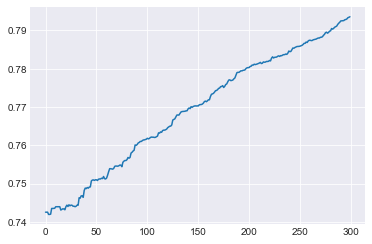

best result: 0.7935885390172553 with 299 estimators

{'min_samples_split': 50, 'learning_rate': 0.005, 'n_estimators': 300}
119.35084104537964 sec
0.793588539017


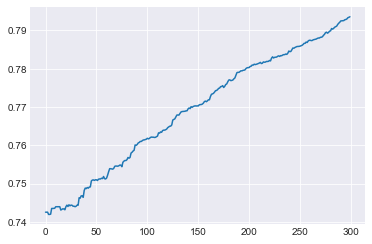

best result: 0.7935885390172553 with 299 estimators

{'min_samples_split': 100, 'learning_rate': 0.005, 'n_estimators': 300}
128.5384442806244 sec
0.793588539017


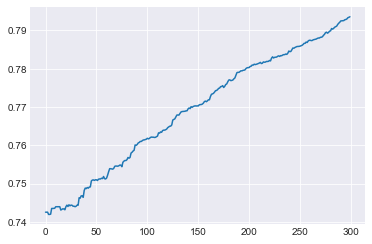

best result: 0.7935885390172553 with 299 estimators

{'min_samples_split': 2, 'learning_rate': 0.01, 'n_estimators': 300}
124.33659482002258 sec
0.809442680696


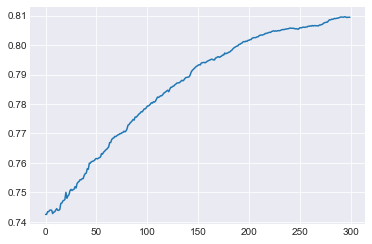

best result: 0.8096033242225885 with 294 estimators

{'min_samples_split': 50, 'learning_rate': 0.01, 'n_estimators': 300}
127.4121994972229 sec
0.809844871875


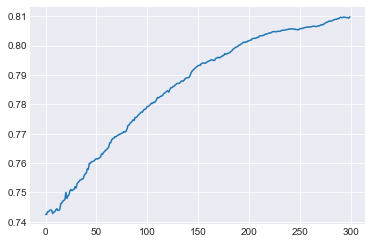

best result: 0.8098448718751993 with 299 estimators

{'min_samples_split': 100, 'learning_rate': 0.01, 'n_estimators': 300}
128.8963565826416 sec
0.809402114714


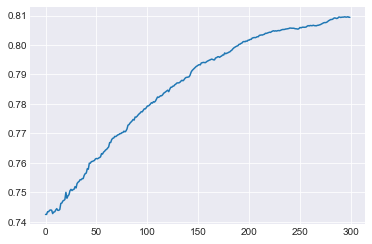

best result: 0.809582294560539 with 297 estimators


In [375]:
params = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [300],
    'min_samples_split': [2, 50, 100]
}

grid = ParameterGrid(params)
for ps in grid:
    cls = GradientBoostingClassifier()
    cls.set_params(**ps)
    print()
    print(ps)
    
    start = time.time()
    cls.fit(X_train, y_train)
    prediction = cls.predict(X_test)
    end = time.time()
    print("{} sec".format(end - start))
    
    print(f1_score(y_test, prediction, average='macro'))
    
    staged_predictions = list(cls.staged_predict(X_test))
    scores = []
    for prediction in staged_predictions:
        scores.append(f1_score(y_test, prediction, average='macro'))
    sns.set_style("darkgrid")
    plt.plot(scores)
    plt.show()
    print("best result: {} with {} estimators".format(np.max(scores), np.argmax(scores)))


{'learning_rate': 0.001, 'n_estimators': 600}
257.41795897483826 sec
0.764003569382


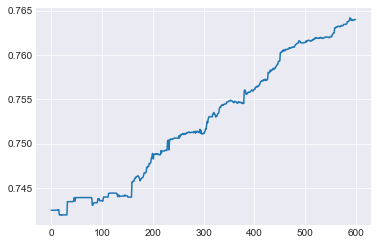

best result: 0.7641992800038743 with 588 estimators

{'learning_rate': 0.003, 'n_estimators': 600}
256.5734717845917 sec
0.797644052852


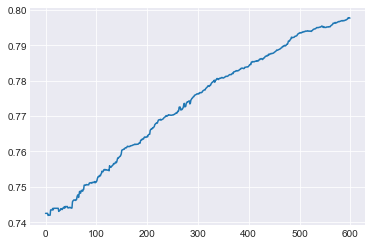

best result: 0.797742896556198 with 598 estimators

{'learning_rate': 0.005, 'n_estimators': 600}
254.48664498329163 sec
0.809695784883


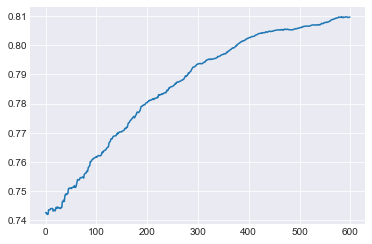

best result: 0.8098240042289478 with 591 estimators

{'learning_rate': 0.01, 'n_estimators': 600}
251.67921018600464 sec
0.823438602445


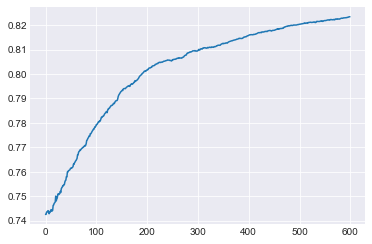

best result: 0.8234552116294381 with 598 estimators

{'learning_rate': 0.03, 'n_estimators': 600}
242.85825109481812 sec
0.837103084669


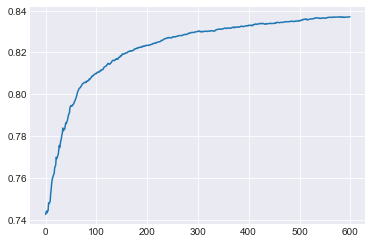

best result: 0.837108352313447 with 580 estimators

{'learning_rate': 0.05, 'n_estimators': 600}
240.21576070785522 sec
0.839041667199


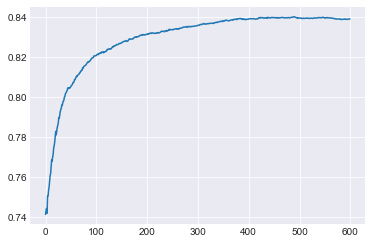

best result: 0.8401919720770286 with 489 estimators


In [376]:
params = {
    'learning_rate': [0.001, 0.003, 0.005, 0.01, 0.03, 0.05],
    'n_estimators': [600],
}

grid = ParameterGrid(params)
for ps in grid:
    cls = GradientBoostingClassifier()
    cls.set_params(**ps)
    print()
    print(ps)
    
    start = time.time()
    cls.fit(X_train, y_train)
    prediction = cls.predict(X_test)
    end = time.time()
    print("{} sec".format(end - start))
    
    print(f1_score(y_test, prediction, average='macro'))
    
    staged_predictions = list(cls.staged_predict(X_test))
    scores = []
    for prediction in staged_predictions:
        scores.append(f1_score(y_test, prediction, average='macro'))
    sns.set_style("darkgrid")
    plt.plot(scores)
    plt.show()
    print("best result: {} with {} estimators".format(np.max(scores), np.argmax(scores)))

#### Try CV with all data

In [77]:
X = X_train.append(X_test)
y = y_train.append(y_test)

In [78]:
X.shape, y.shape

((53333, 80), (53333,))

In [81]:
cv = KFold(n_splits=3, shuffle=True)
cls = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_split=10), 
                         learning_rate=0.005, 
                         n_estimators=80)
scores = cross_val_score(cls, X, y, cv=cv, scoring='f1_macro')
scores

array([ 0.86245572,  0.8637039 ,  0.86081561])

In [82]:
cv = KFold(n_splits=3, shuffle=True)
cls = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_split=10), 
                         learning_rate=0.003, 
                         n_estimators=120)
scores = cross_val_score(cls, X, y, cv=cv, scoring='f1_macro')
scores

array([ 0.85819779,  0.86176775,  0.86655196])